# Example 1 - Missing Completely at Random

In [1]:
import numpy as np
import time
import sys, os
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import miceforest as mf

d = 2
alpha = 1
betas = np.ones(d)
gammas = np.ones(d)

%run 'all_imputations.ipynb'
%run 'all_classifiers.ipynb'

In [2]:
''' Set Constants '''
iterations = 100 # number of iterations for estimating the empirical test error
N_test = 1000

all_accuracies_cc_kNN = np.zeros((2,iterations))
all_accuracies_mi_kNN = np.zeros((2,iterations))
all_accuracies_ci_kNN = np.zeros((2,iterations))
all_accuracies_mf_kNN = np.zeros((2,iterations))
all_accuracies_oracle_HAM = np.zeros((2,iterations))
all_accuracies_HAM = np.zeros((2,iterations))
all_accuracies_cvHAM = np.zeros((2,iterations))
all_accuracies_full_kNN = np.zeros((2,iterations))
all_accuracies_mice_kNN = np.zeros((2,iterations))


u = np.array([np.sqrt(2),0],dtype="float")
Sigma = np.eye(d)
Sigma_inv = np.linalg.inv(Sigma)
w = -np.dot(Sigma_inv,u)

p_MCAR = 0.7 # homogeneous MCAR observation probability

Omega_star = []
Omega_star.append(np.array([1,0],dtype="int"))

def eta(x):
    return np.exp(np.dot(x,w))/(np.exp(np.dot(x,w))+np.exp(-np.dot(x,w)))

Bayes_risk = 0
mean_point = np.zeros(d)
x_point = np.zeros(d)
for _ in range(1000000):
    y_point = np.random.randint(2)
    mean_point = ((-1)**y_point)*u
    x_point = np.random.multivariate_normal(mean_point,Sigma)
    eta_point = eta(x_point)
    Bayes_risk += min(eta_point,1-eta_point)
Bayes_risk = Bayes_risk/1000000
print('Bayes risk = ', np.round(Bayes_risk,4))

Bayes risk =  0.0787


Runtime Complete Case kNN (in s):  1.757
    Accuracy:  0.896
Runtime Mean Imputation and kNN (in s):  1.919
    Accuracy:  0.89
Runtime Constant Imputation and kNN (in s):  1.939
    Accuracy:  0.89
Runtime MissForest and kNN (in s):  2.332
    Accuracy:  0.811
Runtime Oracle HAM (in s):  4.818
    Accuracy:  0.934
Runtime HAM (in s):  5.662
    Accuracy:  0.934
alpha =  2
betas =  [0.25 0.25]
gammas =  [0.5 0.5]
Runtime cvHAM (in s):  96.603
    Accuracy:  0.918
Runtime Full kNN, everything observed (in s):  1.934
    Accuracy:  0.889
Runtime mice and kNN (in s):  41.034
    Accuracy:  0.864

Estimated runtime (in min):  263.329


Test Accuracy Complete Case kNN:  0.8829
Test Accuracy c=0 Imputation then kNN:  0.8816
Test Accuracy Mean Imputation then kNN  :  0.8811
Test Accuracy Random Forest Imputation then kNN:  0.8616
Test Accuracy MissForest then kNN:  0.819
Test Accuracy HAM:  0.9196
Test Accuracy cvHAM:  0.9174
Test Accuracy Oracle HAM:  0.9196
Test Accuracy Full kNN (no missi

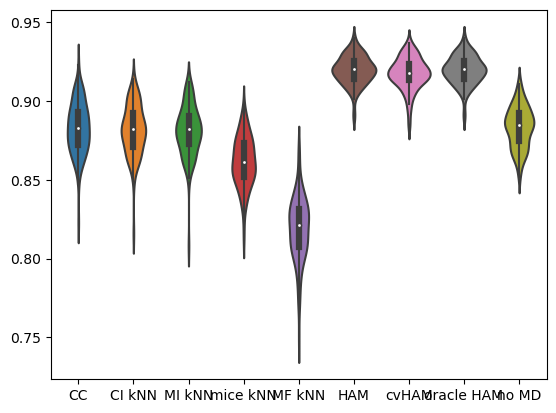

Runtime Complete Case kNN (in s):  2.912
    Accuracy:  0.892
Runtime Mean Imputation and kNN (in s):  3.257
    Accuracy:  0.886
Runtime Constant Imputation and kNN (in s):  3.246
    Accuracy:  0.88
Runtime MissForest and kNN (in s):  3.844
    Accuracy:  0.832
Runtime Oracle HAM (in s):  7.919
    Accuracy:  0.922
Runtime HAM (in s):  11.071
    Accuracy:  0.922
alpha =  0
betas =  [1 1]
gammas =  [0.5 0.5]
Runtime cvHAM (in s):  307.632
    Accuracy:  0.918
Runtime Full kNN, everything observed (in s):  3.253
    Accuracy:  0.899
Runtime mice and kNN (in s):  27.093
    Accuracy:  0.875

Estimated runtime (in min):  617.047


Test Accuracy Complete Case kNN:  0.884
Test Accuracy c=0 Imputation then kNN:  0.883
Test Accuracy Mean Imputation then kNN  :  0.8829
Test Accuracy Random Forest Imputation then kNN:  0.8613
Test Accuracy MissForest then kNN:  0.8183
Test Accuracy HAM:  0.919
Test Accuracy cvHAM:  0.9179
Test Accuracy Oracle HAM:  0.919
Test Accuracy Full kNN (no missingness

In [3]:
'''
EXAMPLE 1 - MCAR
'''

N_train = 500 


''' 
Create 1 training and test point set, show runtime and calculate expected run time for simulation 
'''
# Generate Training Data 
X_train = np.zeros((N_train,d))   # N_train data points
Y_train = np.zeros(N_train)
for i in range(N_train):
    Y_train[i] = np.random.randint(2)   # Y=1 if signs of x[0] and x[1] are different, Y=0 otherwise
    X_train[i] = np.random.multivariate_normal(((-1)**Y_train[i])*u,Sigma)   # normal distribution on [-1,1]^d, 
O_train = np.random.choice(2,size=(N_train,d),p=(1-p_MCAR,p_MCAR))

# Generate Test Points
x_test = np.zeros((N_test,d))
y_test = np.zeros(N_test)
for i in range(N_test):
    y_test[i] = np.random.randint(2)
    x_test[i,:] = np.random.multivariate_normal(((-1)**y_test[i])*u,Sigma) 

%run 'run_different_classifiers_on_data_and_print_times.ipynb'



''' 
Create training and test point sets, estimate empirical test error
'''
accuracy_cc_kNN = np.zeros(iterations)
accuracy_mi_kNN = np.zeros(iterations)
accuracy_ci_kNN = np.zeros(iterations)
accuracy_mf_kNN = np.zeros(iterations)
accuracy_oracle_HAM = np.zeros(iterations)
accuracy_HAM = np.zeros(iterations)
accuracy_cvHAM = np.zeros(iterations)
accuracy_full_kNN = np.zeros(iterations)
accuracy_mice_kNN = np.zeros(iterations)

for it in range(iterations):
    
    # Generate Training Data 
    X_train = np.zeros((N_train,d))   # N_train data points
    Y_train = np.zeros(N_train)
    for i in range(N_train):
        Y_train[i] = np.random.randint(2)   # Y=1 if signs of x[0] and x[1] are different, Y=0 otherwise
        X_train[i] = np.random.multivariate_normal(((-1)**Y_train[i])*u,Sigma)   # normal distribution on [-1,1]^d, 
    O_train = np.random.choice(2,size=(N_train,d),p=(1-p_MCAR,p_MCAR))

    # Generate Test Points
    x_test = np.zeros((N_test,d))
    y_test = np.zeros(N_test)
    for i in range(N_test):
        y_test[i] = np.random.randint(2)
        x_test[i,:] = np.random.multivariate_normal(((-1)**y_test[i])*u,Sigma) 
     
    %run 'run_different_classifiers_on_data.ipynb'
    
    

all_accuracies_cc_kNN[0,:] = accuracy_cc_kNN[0:iterations]
all_accuracies_mi_kNN[0,:] = accuracy_mi_kNN[0:iterations]
all_accuracies_ci_kNN[0,:] = accuracy_ci_kNN[0:iterations]
all_accuracies_mf_kNN[0,:] = accuracy_mf_kNN[0:iterations]
all_accuracies_oracle_HAM[0,:] = accuracy_oracle_HAM[0:iterations]
all_accuracies_HAM[0,:] = accuracy_HAM[0:iterations]
all_accuracies_cvHAM[0,:] = accuracy_cvHAM[0:iterations]
all_accuracies_full_kNN[0,:] = accuracy_full_kNN[0:iterations]
all_accuracies_mice_kNN[0,:] = accuracy_mice_kNN[0:iterations]
    
print('\n\nTest Accuracy Complete Case kNN: ',np.round(np.sum(accuracy_cc_kNN)/iterations,4))
print('Test Accuracy c=0 Imputation then kNN: ',np.round(np.sum(accuracy_ci_kNN)/iterations,4))
print('Test Accuracy Mean Imputation then kNN  : ',np.round(np.sum(accuracy_mi_kNN)/iterations,4))
print('Test Accuracy Random Forest Imputation then kNN: ',np.round(np.sum(accuracy_mice_kNN)/iterations,4))
print('Test Accuracy MissForest then kNN: ',np.round(np.sum(accuracy_mf_kNN)/iterations,4))
print('Test Accuracy HAM: ',np.round(np.sum(accuracy_HAM)/iterations,4))
print('Test Accuracy cvHAM: ',np.round(np.sum(accuracy_cvHAM)/iterations,4))
print('Test Accuracy Oracle HAM: ',np.round(np.sum(accuracy_oracle_HAM)/iterations,4))
print('Test Accuracy Full kNN (no missingness): ',np.round(np.sum(accuracy_full_kNN)/iterations,4))

summary_accuracies = [accuracy_cc_kNN,accuracy_ci_kNN,accuracy_mi_kNN,accuracy_mice_kNN,accuracy_mf_kNN,accuracy_HAM,accuracy_cvHAM,accuracy_oracle_HAM,accuracy_full_kNN]
summary_plot = sns.violinplot(summary_accuracies)

summary_plot.set_xticklabels(['CC','CI kNN','MI kNN','mice kNN','MF kNN','HAM','cvHAM','oracle HAM','no MD'])

plt.show(summary_plot)

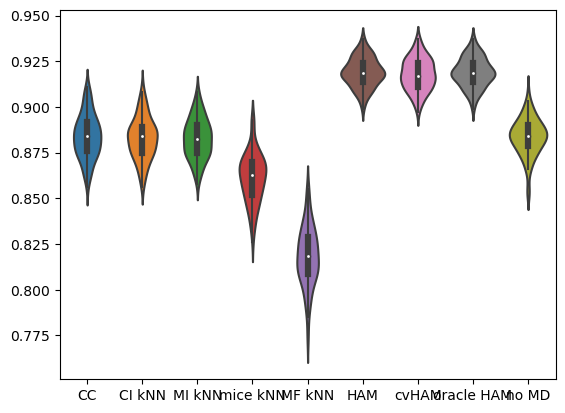

In [4]:
'''
EXAMPLE 1 - MCAR
'''

N_train = 1000 


''' 
Create 1 training and test point set, show runtime and calculate expected run time for simulation 
'''
# Generate Training Data 
X_train = np.zeros((N_train,d))   # N_train data points
Y_train = np.zeros(N_train)
for i in range(N_train):
    Y_train[i] = np.random.randint(2)   # Y=1 if signs of x[0] and x[1] are different, Y=0 otherwise
    X_train[i] = np.random.multivariate_normal(((-1)**Y_train[i])*u,Sigma)   # normal distribution on [-1,1]^d, 
O_train = np.random.choice(2,size=(N_train,d),p=(1-p_MCAR,p_MCAR))

# Generate Test Points
x_test = np.zeros((N_test,d))
y_test = np.zeros(N_test)
for i in range(N_test):
    y_test[i] = np.random.randint(2)
    x_test[i,:] = np.random.multivariate_normal(((-1)**y_test[i])*u,Sigma) 

%run 'run_different_classifiers_on_data_and_print_times.ipynb'



''' 
Create training and test point sets, estimate empirical test error
'''
accuracy_cc_kNN = np.zeros(iterations)
accuracy_mi_kNN = np.zeros(iterations)
accuracy_ci_kNN = np.zeros(iterations)
accuracy_mf_kNN = np.zeros(iterations)
accuracy_oracle_HAM = np.zeros(iterations)
accuracy_HAM = np.zeros(iterations)
accuracy_cvHAM = np.zeros(iterations)
accuracy_full_kNN = np.zeros(iterations)
accuracy_mice_kNN = np.zeros(iterations)

for it in range(iterations):
    
    # Generate Training Data 
    X_train = np.zeros((N_train,d))   # N_train data points
    Y_train = np.zeros(N_train)
    for i in range(N_train):
        Y_train[i] = np.random.randint(2)   # Y=1 if signs of x[0] and x[1] are different, Y=0 otherwise
        X_train[i] = np.random.multivariate_normal(((-1)**Y_train[i])*u,Sigma)   # normal distribution on [-1,1]^d, 
    O_train = np.random.choice(2,size=(N_train,d),p=(1-p_MCAR,p_MCAR))

    # Generate Test Points
    x_test = np.zeros((N_test,d))
    y_test = np.zeros(N_test)
    for i in range(N_test):
        y_test[i] = np.random.randint(2)
        x_test[i,:] = np.random.multivariate_normal(((-1)**y_test[i])*u,Sigma) 
     
    %run 'run_different_classifiers_on_data.ipynb'
    
    

all_accuracies_cc_kNN[1,:] = accuracy_cc_kNN[0:iterations]
all_accuracies_mi_kNN[1,:] = accuracy_mi_kNN[0:iterations]
all_accuracies_ci_kNN[1,:] = accuracy_ci_kNN[0:iterations]
all_accuracies_mf_kNN[1,:] = accuracy_mf_kNN[0:iterations]
all_accuracies_oracle_HAM[1,:] = accuracy_oracle_HAM[0:iterations]
all_accuracies_HAM[1,:] = accuracy_HAM[0:iterations]
all_accuracies_cvHAM[1,:] = accuracy_cvHAM[0:iterations]
all_accuracies_full_kNN[1,:] = accuracy_full_kNN[0:iterations]
all_accuracies_mice_kNN[1,:] = accuracy_mice_kNN[0:iterations]
    
print('\n\nTest Accuracy Complete Case kNN: ',np.round(np.sum(accuracy_cc_kNN)/iterations,4))
print('Test Accuracy c=0 Imputation then kNN: ',np.round(np.sum(accuracy_ci_kNN)/iterations,4))
print('Test Accuracy Mean Imputation then kNN  : ',np.round(np.sum(accuracy_mi_kNN)/iterations,4))
print('Test Accuracy Random Forest Imputation then kNN: ',np.round(np.sum(accuracy_mice_kNN)/iterations,4))
print('Test Accuracy MissForest then kNN: ',np.round(np.sum(accuracy_mf_kNN)/iterations,4))
print('Test Accuracy HAM: ',np.round(np.sum(accuracy_HAM)/iterations,4))
print('Test Accuracy cvHAM: ',np.round(np.sum(accuracy_cvHAM)/iterations,4))
print('Test Accuracy Oracle HAM: ',np.round(np.sum(accuracy_oracle_HAM)/iterations,4))
print('Test Accuracy Full kNN (no missingness): ',np.round(np.sum(accuracy_full_kNN)/iterations,4))

summary_accuracies = [accuracy_cc_kNN,accuracy_ci_kNN,accuracy_mi_kNN,accuracy_mice_kNN,accuracy_mf_kNN,accuracy_HAM,accuracy_cvHAM,accuracy_oracle_HAM,accuracy_full_kNN]
summary_plot = sns.violinplot(summary_accuracies)

summary_plot.set_xticklabels(['CC','CI kNN','MI kNN','mice kNN','MF kNN','HAM','cvHAM','oracle HAM','no MD'])

plt.show(summary_plot)

In [5]:
''' Save accuracies for further use '''

np.save('Ex1_all_accuracies_cc_kNN',all_accuracies_cc_kNN)
np.save('Ex1_all_accuracies_mi_kNN',all_accuracies_mi_kNN)
np.save('Ex1_all_accuracies_ci_kNN',all_accuracies_ci_kNN)
np.save('Ex1_all_accuracies_mf_kNN',all_accuracies_mf_kNN)
np.save('Ex1_all_accuracies_oracle_HAM',all_accuracies_oracle_HAM)
np.save('Ex1_all_accuracies_HAM',all_accuracies_HAM)
np.save('Ex1_all_accuracies_cvHAM',all_accuracies_cvHAM)
np.save('Ex1_all_accuracies_full_kNN',all_accuracies_full_kNN)
np.save('Ex1_all_accuracies_mice_kNN',all_accuracies_mice_kNN)
np.save('Ex1_Bayes_risk',Bayes_risk)


np.save('Ex1_MCAR_all_accuracies_cc_kNN',all_accuracies_cc_kNN)
np.save('Ex1_MCAR_all_accuracies_mi_kNN',all_accuracies_mi_kNN)
np.save('Ex1_MCAR_all_accuracies_ci_kNN',all_accuracies_ci_kNN)
np.save('Ex1_MCAR_all_accuracies_mf_kNN',all_accuracies_mf_kNN)
np.save('Ex1_MCAR_all_accuracies_oracle_HAM',all_accuracies_oracle_HAM)
np.save('Ex1_MCAR_all_accuracies_HAM',all_accuracies_HAM)
np.save('Ex1_MCAR_all_accuracies_cvHAM',all_accuracies_cvHAM)
np.save('Ex1_MCAR_all_accuracies_full_kNN',all_accuracies_full_kNN)
np.save('Ex1_MCAR_all_accuracies_mice_kNN',all_accuracies_mice_kNN)
np.save('Ex1_MCAR_Bayes_risk',Bayes_risk)